# Data Merge

#### 0. Load Required Package & Data

In [1]:
import pandas as pd
import numpy as np
import mpu
import json
import re  
pd.set_option('display.max_columns', None)
house = pd.read_csv('../data/house_combined.csv')
bus = pd.read_csv('../data/bus_stops_file.csv')
train = pd.read_csv('../data/train_stops_file.csv')
tram = pd.read_csv('../data/tram_stops_file.csv')
vline = pd.read_csv('../data/vline_stops_file.csv')
population = pd.read_excel('../data/Population.xlsx')
income = pd.read_excel('../data/Income.xlsx',sheet_name="Forecasted Income")
male = pd.read_excel('../data/Sex & Age by Year.xlsx', sheet_name="Male")
female = pd.read_excel('../data/Sex & Age by Year.xlsx', sheet_name="Female")
school = pd.read_csv('../data/school.csv',sep=",", encoding='cp1252')
hospital = pd.read_csv('../data/hospital_csv',sep=",", encoding='cp1252')
sc = pd.read_csv('../data/shopping_with_postcode.csv')
data_2019 = pd.read_csv('../data/2019_data.csv',sep=",", encoding='cp1252')
data_2020 = pd.read_csv('../data/2020_data.csv',sep=",", encoding='cp1252')
data_2021 = pd.read_csv('../data/2021_data.csv',sep=",", encoding='cp1252')
data_2022 = pd.read_csv('../data/2022_data.csv',sep=",", encoding='cp1252')


#### 1. Properties
Extract needed columns from house_combined.

In [3]:

need_col = [
    "Unnamed: 0",
    "propertyTypes",
    "bathrooms",
    "bedrooms",
    "carspaces",
    "dateUpdated",
    "dateListed",
    "geoLocation",
    "landAreaSqm",
    "postcode",
    "surburb",
    'year', 
    'month',
    'price', 
    'bond',
    'rent'
]

init_house = house[need_col]
init_house.rename(columns={"Unnamed: 0":"index"}, inplace=True)
init_house["geoLocation"] = init_house["geoLocation"].apply(lambda x: re.sub('\'','\"', str(x)))
init_house = init_house[init_house["geoLocation"] != 'nan']
init_house['longitude'] = init_house['geoLocation'].apply(lambda d: json.loads(d)["longitude"])
init_house['latitude'] = init_house['geoLocation'].apply(lambda d: json.loads(d)["latitude"])

/var/folders/74/fx737_kn4xj3gvzzm58zqvm00000gn/T/ipykernel_7007/2580550232.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  init_house.rename(columns={"Unnamed: 0":"index"}, inplace=True)
/var/folders/74/fx737_kn4xj3gvzzm58zqvm00000gn/T/ipykernel_7007/2580550232.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  init_house["geoLocation"] = init_house["geoLocation"].apply(lambda x: re.sub('\'','\"', str(x)))
/var/folders/74/fx737_kn4xj3gvzzm58zqvm00000gn/T/ipykernel_7007/2580550232.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

#### 2. Transportation

##### 2.1 Bus

In [4]:
# Bus
merge_bus = pd.merge(init_house,bus,how='left',on='postcode')
merge_bus["tmp"] = np.sin(merge_bus["stop_latitude"] - merge_bus["latitude"] / 2)**2 + np.cos(merge_bus["latitude"]) * np.cos(merge_bus["stop_latitude"]) * np.sin(merge_bus["stop_longitude"] - merge_bus["longitude"] / 2)**2
merge_bus["bus_stop_distance"] = 2 * np.arctan2(np.sqrt(merge_bus["tmp"]), np.sqrt(1 - merge_bus["tmp"]))


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
bus_stop_min = pd.DataFrame(merge_bus.groupby(["index",'postcode'])["bus_stop_distance"].min())
# bus_stop_min
bus_stop_count = pd.DataFrame(merge_bus.groupby(["index",'postcode'])["bus_stop_distance"].count())
# bus_stop_count
init_house = pd.merge(init_house,bus_stop_min,how='left',left_on=['index','postcode'],right_on=['index','postcode'])
init_house = pd.merge(init_house,bus_stop_count,how='left',left_on=['index','postcode'],right_on=['index','postcode'])
init_house.rename(columns={"bus_stop_distance_x":"distance of the closest bus stop","bus_stop_distance_y":"count of bus stop"}, inplace=True)
# init_house

##### 2.2 Train

In [7]:
merge_train = pd.merge(init_house,train,how='left',on='postcode')
merge_train["tmp"] = np.sin(merge_train["stop_latitude"] - merge_train["latitude"] / 2)**2 + np.cos(merge_train["latitude"]) * np.cos(merge_train["stop_latitude"]) * np.sin(merge_train["stop_longitude"] - merge_bus["longitude"] / 2)**2
merge_train["train_stop_distance"] = 2 * np.arctan2(np.sqrt(merge_train["tmp"]), np.sqrt(1 - merge_train["tmp"]))
train_stop_min = pd.DataFrame(merge_train.groupby(["index",'postcode'])["train_stop_distance"].min())
train_stop_count = pd.DataFrame(merge_train.groupby(["index",'postcode'])["train_stop_distance"].count())
init_house = pd.merge(init_house,train_stop_min,how='left',left_on=['index','postcode'],right_on=['index','postcode'])
init_house = pd.merge(init_house,train_stop_count,how='left',left_on=['index','postcode'],right_on=['index','postcode'])
init_house.rename(columns={"train_stop_distance_x":"distance of the closest train stop","train_stop_distance_y":"count of train stop"}, inplace=True)


##### 2.3 Tram

In [8]:
merge_tram = pd.merge(init_house,tram,how='left',on='postcode')
merge_tram["tmp"] = np.sin(merge_tram["stop_latitude"] - merge_tram["latitude"] / 2)**2 + np.cos(merge_tram["latitude"]) * np.cos(merge_tram["stop_latitude"]) * np.sin(merge_tram["stop_longitude"] - merge_bus["longitude"] / 2)**2
merge_tram["tram_stop_distance"] = 2 * np.arctan2(np.sqrt(merge_tram["tmp"]), np.sqrt(1 - merge_tram["tmp"]))
tram_stop_min = pd.DataFrame(merge_tram.groupby(["index",'postcode'])["tram_stop_distance"].min())
tram_stop_count = pd.DataFrame(merge_tram.groupby(["index",'postcode'])["tram_stop_distance"].count())
init_house = pd.merge(init_house,tram_stop_min,how='left',left_on=['index','postcode'],right_on=['index','postcode'])
init_house = pd.merge(init_house,tram_stop_count,how='left',left_on=['index','postcode'],right_on=['index','postcode'])
init_house.rename(columns={"tram_stop_distance_x":"distance of the closest tram stop","tram_stop_distance_y":"count of tram stop"}, inplace=True)

##### 2.4 Vline

In [9]:
merge_vline = pd.merge(init_house,vline,how='left',on='postcode')
merge_vline["tmp"] = np.sin(merge_vline["stop_latitude"] - merge_vline["latitude"] / 2)**2 + np.cos(merge_vline["latitude"]) * np.cos(merge_vline["stop_latitude"]) * np.sin(merge_vline["stop_longitude"] - merge_vline["longitude"] / 2)**2
merge_vline["vline_stop_distance"] = 2 * np.arctan2(np.sqrt(merge_vline["tmp"]), np.sqrt(1 - merge_vline["tmp"]))
vline_stop_min = pd.DataFrame(merge_vline.groupby(["index",'postcode'])["vline_stop_distance"].min())
vline_stop_count = pd.DataFrame(merge_vline.groupby(["index",'postcode'])["vline_stop_distance"].count())
init_house = pd.merge(init_house,vline_stop_min,how='left',left_on=['index','postcode'],right_on=['index','postcode'])
init_house = pd.merge(init_house,vline_stop_count,how='left',left_on=['index','postcode'],right_on=['index','postcode'])
init_house.rename(columns={"vline_stop_distance_x":"distance of the closest vline stop","vline_stop_distance_y":"count of vline stop"}, inplace=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


#### 3. Facilities

##### 3.1 School

In [10]:
merge_school = pd.merge(init_house,school,how='left',left_on='postcode',right_on="Address_Postcode")
merge_school["tmp"] = np.sin(merge_school["Y"] - merge_school["latitude"] / 2)**2 + np.cos(merge_school["latitude"]) * np.cos(merge_school["Y"]) * np.sin(merge_school["X"] - merge_vline["longitude"] / 2)**2
merge_school["school_distance"] = 2 * np.arctan2(np.sqrt(merge_school["tmp"]), np.sqrt(1 - merge_school["tmp"]))
school_stop_min = pd.DataFrame(merge_school.groupby(["index",'Address_Postcode'])["school_distance"].min())
school_stop_count = pd.DataFrame(merge_school.groupby(["index",'Address_Postcode'])["school_distance"].count())
init_house = pd.merge(init_house,school_stop_min,how='left',left_on=['index','postcode'],right_on=['index','Address_Postcode'])
init_house = pd.merge(init_house,school_stop_count,how='left',left_on=['index','postcode'],right_on=['index','Address_Postcode'])
init_house.rename(columns={"school_distance_x":"distance of the closest school","school_distance_y":"count of school"}, inplace=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


##### 3.2 Hospital

In [11]:
merge_hospital = pd.merge(init_house,hospital,how='left',on='postcode')
merge_hospital
hospital_count = pd.DataFrame(merge_hospital.groupby(["index",'postcode'])["name"].count())
hospital_count
init_house = pd.merge(init_house,hospital_count,how='left',left_on=['index','postcode'],right_on=['index','postcode'])
init_house.rename(columns={"name":"count of hospital"}, inplace=True)

##### 3.3 Shopping Center/Malls

In [13]:
# get lat & lon from shopping center data file
a = sc['Location'].str.split(",",n = 1, expand = True)
sc['stop_longitude']=a[1]
b = a[0].str.split(":",n = 1, expand = True)
sc['stop_latitude']=b[1]


In [14]:
# update data type for lat and long extracted
sc = sc.astype({'stop_longitude': 'float'})
sc = sc.astype({'stop_latitude': 'float'})
sc.dtypes

Unnamed: 0          int64
Name               object
Suburb             object
Location           object
postcode            int64
stop_longitude    float64
stop_latitude     float64
dtype: object

In [15]:
merge_sc = pd.merge(init_house, sc, how='left',on='postcode')
merge_sc
merge_sc["tmp"] = np.sin(merge_sc["stop_latitude"] - merge_sc["latitude"] / 2)**2 + np.cos(merge_sc["latitude"]) * np.cos(merge_sc["stop_latitude"]) * np.sin(merge_sc["stop_longitude"] - merge_vline["longitude"] / 2)**2
merge_sc["sc_distance"] = 2 * np.arctan2(np.sqrt(merge_sc["tmp"]), np.sqrt(1 - merge_sc["tmp"]))
sc_stop_min = pd.DataFrame(merge_sc.groupby(["index",'postcode'])["sc_distance"].min())
sc_stop_count = pd.DataFrame(merge_sc.groupby(["index",'postcode'])["sc_distance"].count())
init_house = pd.merge(init_house,sc_stop_min,how='left',left_on=['index','postcode'],right_on=['index','postcode'])
init_house = pd.merge(init_house,sc_stop_count,how='left',left_on=['index','postcode'],right_on=['index','postcode'])
init_house.rename(columns={"sc_distance_x":"distance to the closest shopping mall","sc_distance_y":"count of shopping mall"}, inplace=True)
# init_house


In [16]:
merge_sc
merge_sc[merge_sc["index"]==114449]

,index,propertyTypes,bathrooms,bedrooms,carspaces,dateUpdated,dateListed,geoLocation,landAreaSqm,postcode,surburb,year,month,price,bond,rent,longitude,latitude,distance of the closest bus stop,count of bus stop,distance of the closest train stop,count of train stop,distance of the closest tram stop,count of tram stop,distance of the closest vline stop,count of vline stop,distance of the closest school,count of school,count of hospital,Unnamed: 0,Name,Suburb,Location,stop_longitude,stop_latitude,tmp,sc_distance
396335,114449,['apartmentUnitFlat'],2.0,2.0,0.0,2022-08-02T00:16:50.887Z,2022-07-29T10:40:25Z,"{""latitude"": -37.8093086, ""longitude"": 144.959...",NaN,3000,melbourne,2022,8,$550 pw,NaN,550.0,144.959739,-37.809309,0.450907,19,0.385171,1,0.727245,23,0.448499,1,NaN,0.0,4,0.0,206 BOURKE STREET Victoria,Melbourne,"GPS: -37.812733,144.966947",144.966947,-37.812733,NaN,NaN
396336,114449,['apartmentUnitFlat'],2.0,2.0,0.0,2022-08-02T00:16:50.887Z,2022-07-29T10:40:25Z,"{""latitude"": -37.8093086, ""longitude"": 144.959...",NaN,3000,melbourne,2022,8,$550 pw,NaN,550.0,144.959739,-37.809309,0.450907,19,0.385171,1,0.727245,23,0.448499,1,NaN,0.0,4,2.0,ALTONA GATE SHOPPING CENTRE Victoria,Melbourne,"GPS: -37.828989,144.84627",144.846270,-37.828989,NaN,NaN
396337,114449,['apartmentUnitFlat'],2.0,2.0,0.0,2022-08-02T00:16:50.887Z,2022-07-29T10:40:25Z,"{""latitude"": -37.8093086, ""longitude"": 144.959...",NaN,3000,melbourne,2022,8,$550 pw,NaN,550.0,144.959739,-37.809309,0.450907,19,0.385171,1,0.727245,23,0.448499,1,NaN,0.0,4,14.0,BOURKE STREET MALL Victoria,Melbourne,"GPS: -37.813538,144.964386",144.964386,-37.813538,NaN,NaN
396338,114449,['apartmentUnitFlat'],2.0,2.0,0.0,2022-08-02T00:16:50.887Z,2022-07-29T10:40:25Z,"{""latitude"": -37.8093086, ""longitude"": 144.959...",NaN,3000,melbourne,2022,8,$550 pw,NaN,550.0,144.959739,-37.809309,0.450907,19,0.385171,1,0.727245,23,0.448499,1,NaN,0.0,4,25.0,CAMPBELLFIELD PLAZA Victoria,Melbourne,"GPS: -37.689343,144.960737",144.960737,-37.689343,NaN,NaN
396339,114449,['apartmentUnitFlat'],2.0,2.0,0.0,2022-08-02T00:16:50.887Z,2022-07-29T10:40:25Z,"{""latitude"": -37.8093086, ""longitude"": 144.959...",NaN,3000,melbourne,2022,8,$550 pw,NaN,550.0,144.959739,-37.809309,0.450907,19,0.385171,1,0.727245,23,0.448499,1,NaN,0.0,4,38.0,COLLINS PLACE Victoria,Melbourne,"GPS: -37.814312,144.97268",144.972680,-37.814312,NaN,NaN
396340,114449,['apartmentUnitFlat'],2.0,2.0,0.0,2022-08-02T00:16:50.887Z,2022-07-29T10:40:25Z,"{""latitude"": -37.8093086, ""longitude"": 144.959...",NaN,3000,melbourne,2022,8,$550 pw,NaN,550.0,144.959739,-37.809309,0.450907,19,0.385171,1,0.727245,23,0.448499,1,NaN,0.0,4,39.0,COLLINS234 BOUTIQUE PLACE Victoria,Melbourne,"GPS: -37.815545,144.965749",144.965749,-37.815545,NaN,NaN
396341,114449,['apartmentUnitFlat'],2.0,2.0,0.0,2022-08-02T00:16:50.887Z,2022-07-29T10:40:25Z,"{""latitude"": -37.8093086, ""longitude"": 144.959...",NaN,3000,melbourne,2022,8,$550 pw,NaN,550.0,144.959739,-37.809309,0.450907,19,0.385171,1,0.727245,23,0.448499,1,NaN,0.0,4,58.0,EMPORIUM MELBOURNE Victoria,Melbourne,"GPS: -37.812517,144.963555",144.963555,-37.812517,NaN,NaN
396342,114449,['apartmentUnitFlat'],2.0,2.0,0.0,2022-08-02T00:16:50.887Z,2022-07-29T10:40:25Z,"{""latitude"": -37.8093086, ""longitude"": 144.959...",NaN,3000,melbourne,2022,8,$550 pw,NaN,550.0,144.959739,-37.809309,0.450907,19,0.385171,1,0.727245,23,0.448499,1,NaN,0.0,4,61.0,FEDERATION SQUARE (FED SQUARE) Victoria,Melbourne,"GPS: -37.81797,144.969024",144.969024,-37.817970,NaN,NaN
396343,114449,['apartmentUnitFlat'],2.0,2.0,0.0,2022-08-02T00:16:50.887Z,2022-07-29T10:40:25Z,"{""latitude"": -37.8093086, ""longitude"": 144.959...",NaN,3000,melbourne,2022,8,$550 pw,NaN,550.0,144.959739,-37.809309,0.450907,19,0.385171,1,0.727245,23,0.448499,1,NaN,0.0,4,66.0,GALLERIA MELBOURNE Victoria,Melbourne,"GPS: -37.814824,144.962743",144.962743,-37.814824,NaN,NaN
396344,114449,['apartmentUnitFlat'],2.0,2.0,0.0,2022-08-02T00:16:50.887Z,2022-07-29T10:40:25Z,"{""la

In [17]:
init_house[init_house["postcode"]==3000]

,index,propertyTypes,bathrooms,bedrooms,carspaces,dateUpdated,dateListed,geoLocation,landAreaSqm,postcode,surburb,year,month,price,bond,rent,longitude,latitude,distance of the closest bus stop,count of bus stop,distance of the closest train stop,count of train stop,distance of the closest tram stop,count of tram stop,distance of the closest vline stop,count of vline stop,distance of the closest school,count of school,count of hospital,distance to the closest shopping mall,count of shopping mall
90,90,['apartmentUnitFlat'],1.0,1.0,0.0,2019-01-08T06:47:15.953Z,2019-01-03T00:32:26Z,"{""latitude"": -37.8181709, ""longitude"": 144.964...",NaN,3000,melbourne,2019,1,$400.00 per week,NaN,400.0,144.964354,-37.818171,0.443720,19,0.464434,1,0.467878,23,0.441336,1,0.455627,4.0,4,0.271425,26
1752,1752,['apartmentUnitFlat'],1.0,1.0,1.0,2020-03-03T04:06:07.627Z,2020-02-25T05:20:07Z,"{""latitude"": -37.8204251, ""longitude"": 144.968...",NaN,3000,melbourne,2020,3,475.0,2550.0,NaN,144.968945,-37.820425,0.438642,19,0.462861,1,0.456706,23,0.436261,1,0.383381,4.0,4,0.262054,26
1960,1960,['apartmentUnitFlat'],1.0,1.0,1.0,2021-02-08T23:52:24.94Z,2021-01-25T01:53:00Z,"{""latitude"": -37.8110844, ""longitude"": 144.971...",NaN,3000,melbourne,2021,2,400.0,2000.0,NaN,144.971466,-37.811084,0.439175,19,0.461530,1,0.463099,23,0.436762,1,0.366230,4.0,4,0.266700,26
2088,2088,['apartmentUnitFlat'],1.0,2.0,0.0,2021-11-29T00:28:31.043Z,2021-11-15T05:34:06Z,"{""latitude"": -37.8156715, ""longitude"": 144.952...",NaN,3000,melbourne,2021,11,350.0,1521.0,NaN,144.952974,-37.815672,0.455368,19,0.467794,1,0.468641,23,0.452986,1,0.378469,4.0,4,0.246024,26
2118,2118,['apartmentUnitFlat'],1.0,1.0,1.0,2022-02-10T23:26:49.223Z,2022-01-12T00:21:12Z,"{""latitude"": -37.8148884, ""longitude"": 144.954...",NaN,3000,melbourne,2022,2,400.0,1738.0,NaN,144.954228,-37.814888,0.454409,19,0.394217,1,0.467752,23,0.452023,1,0.381802,4.0,4,0.271739,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111173,112163,['apartmentUnitFlat'],1.0,2.0,0.0,2022-05-21T11:04:12.18Z,2022-05-15T04:14:28Z,"{""latitude"": -37.8201858, ""longitude"": 144.956...",NaN,3000,melbourne,2022,5,"$550 pw, fully furnished with stunning views",NaN,550.0,144.956463,-37.820186,0.450662,19,0.387636,1,0.623240,23,0.448291,1,NaN,0.0,4,NaN,0
111175,112165,['apartmentUnitFlat'],1.0,1.0,0.0,2022-06-30T00:49:02.67Z,2022-05-26T06:20:55Z,"{""latitude"": -37.817664, ""longitude"": 144.957957}",NaN,3000,melbourne,2022,6,$360,NaN,360.0,144.957957,-37.817664,0.449993,19,0.308087,1,0.623835,23,0.447613,1,NaN,0.0,4,NaN,0
111177,112167,['apartmentUnitFlat'],1.0,1.0,0.0,2022-06-23T05:19:02.9Z,2022-06-14T05:39:17Z,"{""latitude"": -37.817664, ""longitude"": 144.957957}",NaN,3000,melbourne,2022,6,$360 pw incl utilities and furnished,NaN,360.0,144.957957,-37.817664,0.449993,19,0.308087,1,0.623835,23,0.447613,1,NaN,0.0,4,NaN,0
113130,114391,['apartmentUnitFlat'],2.0,2.0,1.0,2020-11-18T04:38:19.027Z,2020-11-03T11:41:05Z,"{""latitude"": -37.811464, ""longitude"": 144.9717...",NaN,3000,melbourne,2020,11,$580 per week,NaN,580.0,144.971724,-37.811464,0.438807,19,0.377363,1,0.420867,23,0.436394,1,NaN,0.0,4,NaN,0


<AxesSubplot:>

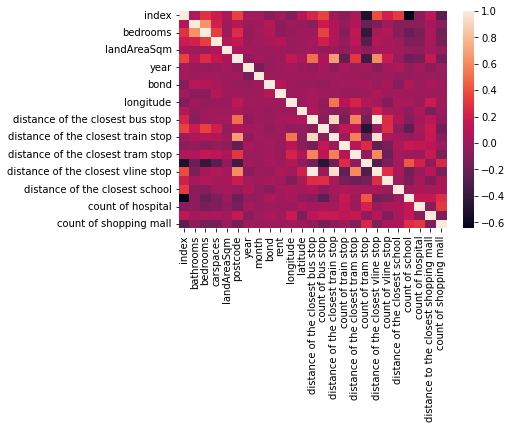

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
# plt.subplots()
# ax = plt.axes()
corr = init_house.corr()
sns.heatmap(corr)

In [ ]:
# Save merged data table to curated folder
# init_house.to_csv("../data/curated/init_house.csv")

#### 4. Population, income and Sex

##### 4.1 Population

In [19]:
population = pd.read_excel('../data/Population.xlsx', sheet_name="Pop", header=[0,1])

df_pop =population.set_index([('Unnamed: 0_level_0', 'SA2 code'),('Unnamed: 1_level_0', 'SA2 name')])
stacked_pop=df_pop.stack()
stacked_pop


Population   \
(Unnamed: 0_level_0, SA2 code) (Unnamed: 1_level_0, SA2 name)                      
201011001                      Alfredton                      2019  14408.000000   
                                                              2020  15472.000000   
                                                              2021  16823.000000   
                                                              2022  18044.196846   
201011002                      Ballarat                       2019  12311.000000   
...                                                                          ...   
217041479                      Warrnambool - North            2022  22671.843739   
217041480                      Warrnambool - South            2019  13247.000000   
                                                              2020  13323.000000   
                                                              2021  13292.000000   
                                                              2022  13315.972701   

                                                                    Population Increase  
(Unnamed: 0_level_0, SA2 code) (Unnamed: 1_level_0, SA2 name)                            
201011001                      Alfredton                      2019             0.065680  
                                                              2020             0.073848  
                                                              2021             0.087319  
                                                              2022             0.072591  
201011002                      Ballarat                       2019             0.006047  
...                                                                                 ...  
217041479                      Warrnambool - North            2022             0.009342  
217041480                      Warrnambool - South            2019             0.002497  
                                                              2020             0.005737  
                                                              2021            -0.002327  
                                                              2022             0.001804  

[2083 rows x 2 columns]

##### 4.2 Income

In [20]:
income = pd.read_excel('../data/Income.xlsx',sheet_name="Forecasted Income", header=[0,1])
df_income =income.set_index([('Unnamed: 0_level_0','SA2'),('Unnamed: 1_level_0', 'SA2 NAME'),('Unnamed: 2_level_0', 'Postcode')])
stacked_income=df_income.stack()
stacked_income


Earners (persons)  \
(Unnamed: 0_level_0, SA2) (Unnamed: 1_level_0, SA2 NAME) (Unnamed: 2_level_0, Postcode)                           
201011001                 Alfredton                      3350.0                         2019        8503.447540   
                                                                                        2020        9019.555013   
                                                                                        2021        9567.571661   
                                                                                        2022       10148.885100   
201011002                 Ballarat                       3350.0                         2019        7673.610510   
...                                                                                                         ...   
217041479                 Warrnambool - North            NaN                            2022       13954.601692   
217041480                 Warrnambool - South            NaN                            2019        8215.899526   
                                                                                        2020        8382.930428   
                                                                                        2021        8587.396223   
                                                                                        2022        8587.396223   

                                                                                                  Mean ($)  \
(Unnamed: 0_level_0, SA2) (Unnamed: 1_level_0, SA2 NAME) (Unnamed: 2_level_0, Postcode)                      
201011001                 Alfredton                      3350.0                         2019  65636.394852   
                                                                                        2020  67773.311518   
                                                                                        2021  69862.748812   
                                                                                        2022  71889.039229   
201011002                 Ballarat                       3350.0                         2019  80837.265352   
...                                                                                                    ...   
217041479                 Warrnambool - North            NaN                            2022  62583.220506   
217041480                 Warrnambool - South            NaN                            2019  60325.970235   
                                                                                        2020  62927.536964   
                                                                                        2021  65621.810743   
                                                                                        2022  68633.603632   

                                                                                                Median ($)  \
(Unnamed: 0_level_0, SA2) (Unnamed: 1_level_0, SA2 NAME) (Unnamed: 2_level_0, Postcode)                      
201011001                 Alfredton                      3350.0                         2019  55374.162543   
                                                                                        2020  56981.756185   
                                                                                        2021  58628.439829   
                                                                                        2022  60284.180114   
201011002                 Ballarat                       3350.0                         2019  55244.566537   
...                                                                                                    ...   
217041479                 Warrnambool - North            NaN                            2022  56700.443532   
217041480                 Warrnambool - South            NaN                            2019  48760.212040   
                                                                   

In [21]:
# population = pd.read_excel('../data/Population.xlsx')
# income = pd.read_excel('../data/Income.xlsx',sheet_name="Forecasted Income")
# male = pd.read_excel('../data/Sex & Age by Year.xlsx', sheet_name="Male")
# female = pd.read_excel('../data/Sex & Age by Year.xlsx', sheet_name="Female")

##### 4.3 Sex Ratio

In [22]:
sex_ratio = pd.read_excel('../data/Sex & Age by Year.xlsx', sheet_name="Ratio", header=[0,1])
df_sex =sex_ratio.set_index([('Unnamed: 0_level_0', 'SA2')])
stacked_sex=df_sex.stack()
stacked_sex


Female  Female Ratio          Male  \
(Unnamed: 0_level_0, SA2)                                                  
201011001                 2019   7331.000000      0.508815   7077.000000   
                          2020   7882.000000      0.509436   7590.000000   
                          2021   8585.000000      0.510313   8238.000000   
                          2022   9217.148629      0.510810   8827.102822   
201011002                 2019   6437.000000      0.522866   5874.000000   
...                                      ...           ...           ...   
217041479                 2022  11723.290235      0.517086  10948.631716   
217041480                 2019   6840.000000      0.516343   6407.000000   
                          2020   6875.000000      0.516025   6448.000000   
                          2021   6866.000000      0.516551   6426.000000   
                          2022   6877.068708      0.516453   6438.908610   

                                Male Ratio        Person  
(Unnamed: 0_level_0, SA2)                                 
201011001                 2019    0.491185  14408.000000  
                          2020    0.490564  15472.000000  
                          2021    0.489687  16823.000000  
                          2022    0.489193  18044.196846  
201011002                 2019    0.477134  12311.000000  
...                                    ...           ...  
217041479                 2022    0.482918  22671.843739  
217041480                 2019    0.483657  13247.000000  
                          2020    0.483975  13323.000000  
                          2021    0.483449  13292.000000  
                          2022    0.483548  13315.972701  

[1844 rows x 5 columns]

In [24]:
# merge_stack = pd.merge(stacked_pop,stacked_income,how='left',on='postcode')

In [ ]:
# population
# income
# header = pd.MultiIndex.from_product([['Earner','Median_age','Sum', 'median', 'mean'],['2019','2020','2021','2022']])
# # d=([[12,45,67,56],[78,89,45,67],[45,67,89,90],[67,44,56,55]])
# income_earner = income.iloc[:,[3,4,5,6]]
# income_median_age = income.iloc[:,[7,8,9,10]]
# income_sum = income.iloc[:,[11,12,13,14]]
# income_median = income.iloc[:,[15,16,17,18]]
# income_mean = income.iloc[:,[19,20,21,22]]
# income_earner
# df = pd.DataFrame([income_earner,income_median_age,income_sum,income_median,income_mean],columns=header)
# df
# income_mean